# Quantum Approximate Optimization Algorithm

In [56]:
import numpy as np
import qaoa
import networkx as nx
from qaoa.problems import Problem, ProblemKind
from qaoa.optimization import solve_qaoa
import matplotlib.pyplot as plt

## Problema aleatorio

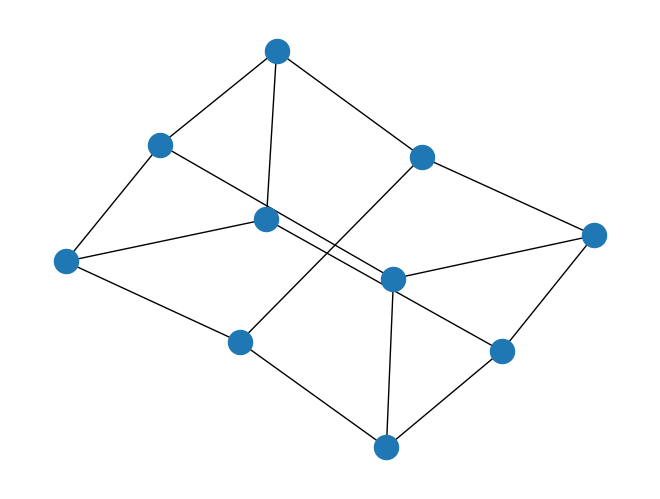

In [66]:
g = nx.random_regular_graph(d=3, n=10, seed=123888472)
nx.draw(g)

In [67]:
def plot_qaoa(E, psi, bounds=False, ax=None):
    N = len(E)
    if ax is None:
        fig, ax = plt.subplots()
    y = np.abs(psi)**2
    ax.plot(E, y, '.', label='Muestreo')
    ndx = np.argmin(E)
    ax.plot(E[ndx], y[ndx], 'ro', label='Óptimo')
    p = np.polyfit(E, np.log(y), deg=1)
    if bounds:
        ax.set_ylim(*bounds)
    ax.plot(E, np.exp(np.polyval(p, E)), '-.', label='Termodinámica')
    ax.set_title(f'P(óptimo) = {y[ndx]*100:3.1f}%')
    ax.legend()
    ax.set_yscale('log')
    ax.set_xlabel('Coste')
    ax.set_ylabel('Probabilidad')

## Solución con QAOA
El problema a resolver define un circuito cuántico que aproxima la solución.
![Circuito QAOA](../images/circuito-qaoa.png)

## Solución con QAOA

In [68]:
p = Problem(kind=ProblemKind.MAXCUT, J=nx.to_numpy_array(g))
theta, gamma, energy, nit, E, psi = solve_qaoa(p.energy_vector(), layers=1, return_state=True)

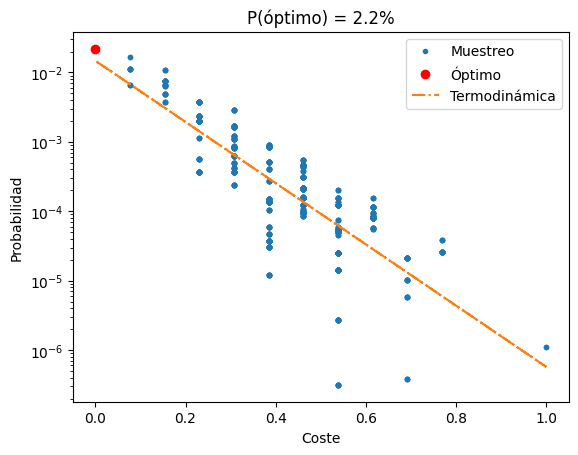

In [69]:
plot_qaoa(E, psi)

La solución óptima es la más probable, pero no excesivamente probable.

## Influencia de los ángulos

In [70]:
from qaoa.p_layers_cython import traditional_QAOA_state
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def qaoa_dist(problem, gamma, theta=0.785):
    E = problem.energy_vector()
    psi = traditional_QAOA_state([theta], [gamma], E)
    plot_qaoa(E, psi, bounds=(1e-6,0.1))

def qaoa_int(problem):
    N = problem.size
    max_gamma = 2*np.pi*np.log(N)/np.log(2.0)
    x = widgets.IntSlider(min=0, max=max_gamma, step=max_gamma/21)
    interact(lambda x: qaoa_dist(p, x), x=x);

Hemos descubierto que, en el rango de parámetros donde el circuito funciona, se comporta como una máquina de Boltzman (un simulador de sistemas físicos a temperaturas finitas).

In [71]:
qaoa_int(p);

interactive(children=(IntSlider(value=0, description='x', max=20, step=0), Output()), _dom_classes=('widget-in…

Esto nos permite diseñar *a priori* los ángulos necesarios para la optimización, con menor consumo de recursos.

## QAOA multicapa

In [76]:
from qaoa.optimization import OptimalAnglesExperiment
import pickle
import os

def qaoa_multilayer_show(problem, max_layers=13, cache="qaoa-large-cache.pkl"):
    if cache and os.path.exists(cache):
        with open(cache, "rb") as f:
            expt = pickle.load(f)
    else:
        max_layers = 10
        expt = []
        solution = None
        E = problem.energy_vector()
        for l in range(1, max_layers+1):
            solution = OptimalAnglesExperiment(E,
                                               layers=l,
                                               previous=solution,
                                               fit=False,
                                               use_cython=True,
                                               smooth_interpolation=True)
            expt.append((solution.theta, solution.gamma, solution.psi))
        if cache:
            with open(cache, "wb") as f:
                pickle.dump(expt, f)

    def plot_this(ndx):
        fig, ax = plt.subplots(ncols=2, figsize=(8,5))
        for i, (theta, gamma, psi) in enumerate(expt):
            cum_theta = np.cumsum(theta)
            cum_gamma = np.cumsum(gamma)
            style="b."
            if i == ndx:
                plot_qaoa(p.energy_vector(), psi, ax=ax[0], bounds=(1e-6,0.3))
                style = "ro"
            ax[1].plot(cum_theta / cum_theta[-1], cum_gamma / cum_gamma[-1], style)
        ax[1].set_xlabel(r"$\int\theta$")
        ax[1].set_ylabel(r"$\int\gamma$")

    interact(plot_this, ndx=widgets.IntSlider(min=0, max=max_layers-1));

In [77]:
p = Problem(kind=ProblemKind.MAXCUT, J=nx.to_numpy_array(g))
qaoa_multilayer_show(p)

interactive(children=(IntSlider(value=0, description='ndx', max=9), Output()), _dom_classes=('widget-interact'…